<a href="https://colab.research.google.com/github/ruwan97/Rubber_Leaf_Disease_Detection/blob/main/Rubber_Leaf_Disease_Detection_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
data_directory = "/content/drive/MyDrive/ResearchData/train"

Now we have a `ReaearchData` folder which contain three subfolders, 

`Colletotrichum` and `corynespora` and `oidium`. Each
 subfolder contains image files for each category.


In [13]:
!ls "/content/drive/MyDrive/ResearchData/train"


Colletotrichum	corynespora  oidium


## Generate a `Dataset`


In [14]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/ResearchData/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/ResearchData/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 1288 files belonging to 3 classes.
Using 1031 files for training.
Found 1288 files belonging to 3 classes.
Using 257 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset.


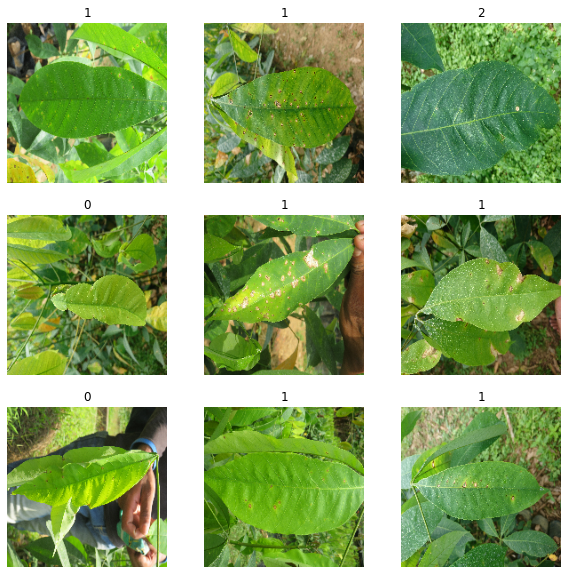

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [16]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


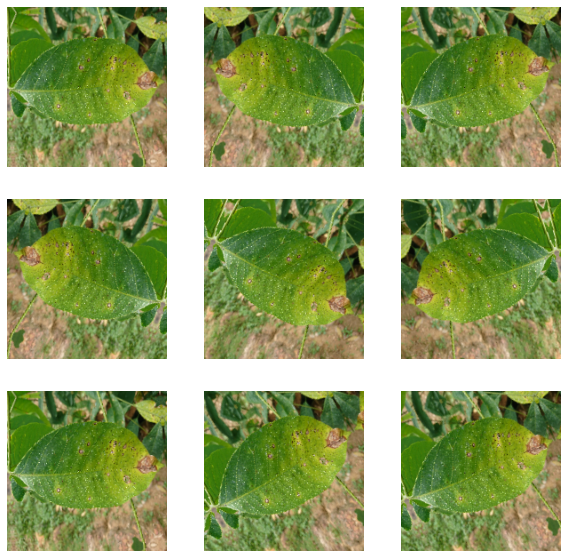

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [18]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture.
Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


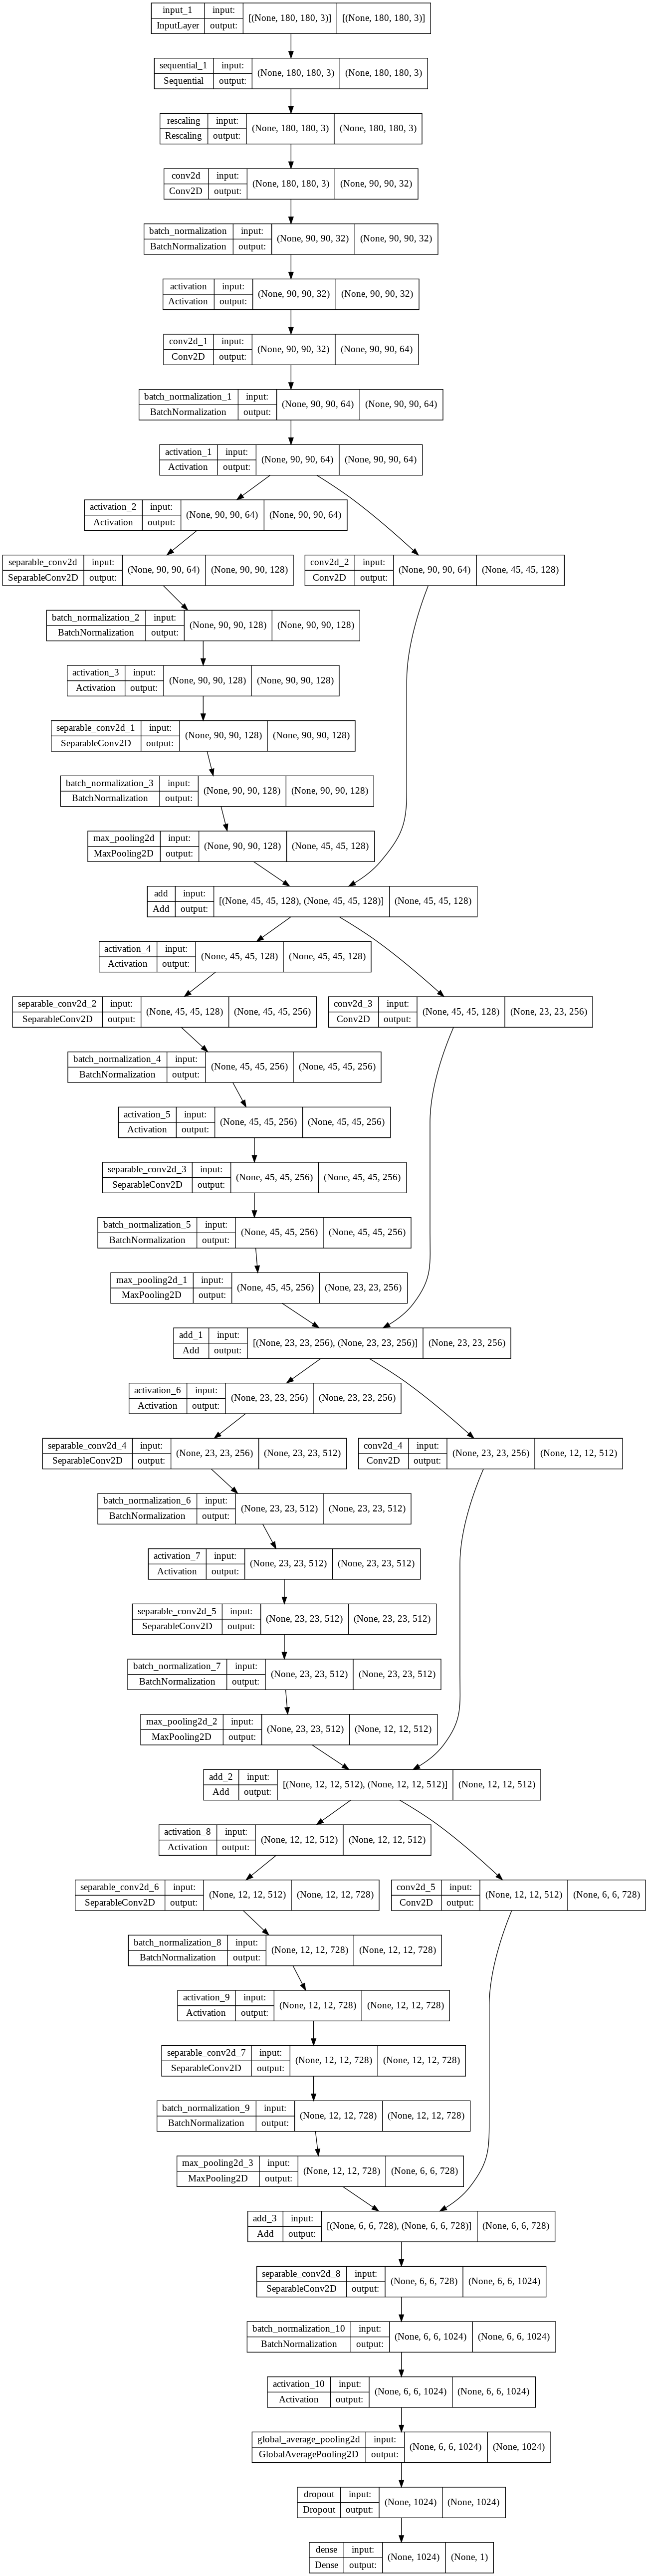

In [19]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


## Train the model


In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/model/save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/10
33/33 [==============================] - 504s 14s/step - loss: -5.6681 - accuracy: 0.3366 - val_loss: -0.4104 - val_accuracy: 0.5681
Epoch 2/10
33/33 [==============================] - 416s 11s/step - loss: -17.2658 - accuracy: 0.4879 - val_loss: -1.1936 - val_accuracy: 0.5681
Epoch 3/10
33/33 [==============================] - 421s 11s/step - loss: -29.8380 - accuracy: 0.4956 - val_loss: -2.7935 - val_accuracy: 0.5681
Epoch 4/10
33/33 [==============================] - 428s 12s/step - loss: -46.3710 - accuracy: 0.5082 - val_loss: -6.5976 - val_accuracy: 0.5681
Epoch 5/10
33/33 [==============================] - 424s 12s/step - loss: -66.7195 - accuracy: 0.5082 - val_loss: -14.5803 - val_accuracy: 0.5681
Epoch 6/10
33/33 [==============================] - 417s 12s/step - loss: -89.5036 - accuracy: 0.5082 - val_loss: -26.9537 - val_accuracy: 0.5681
Epoch 7/10
33/33 [==============================] - 428s 12s/step - loss: -119.4058 - accuracy: 0.5082 - val_loss: -52.9024 - val

We get to ~96% validation accuracy after training for 50 epochs on the full dataset.
